---
layout: page
title: Confiança, Tendência Central e Dispersão
nav_order: 16
---
[<img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/flaviovdf/fcd/blob/master/_lessons/16-Confianca.ipynb)

# Tópico 16 – Confiança, Tendência Central e Dispersão
{: .no_toc .mb-2 }

Após aprender a quantificar a incerteza de uma estimativa através dos intervalos de confiança construídos via bootstrap, é hora de nos aprofundarmos na interpretação desses intervalos, e formalizar algumas noções da "centralidade" e da "variabilidade" dos valores de uma distribuição. Ao longo dessa aula, introduziremos também outras maneiras de quantificar a incerteza e a probabilidade de um conjunto de valores de uma distribuição através de uma construção matemática, baseada na teoria de Probabilidade.
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados

1. Aprender a interpretar intervalos de confiança.
1. Aprender a identificar as situações onde espera-se que o bootstrap dê bons resultados (ou não).
1. Introduzir e definir medidas de tendência central e de dispersão.
1. Introduzir e aprender como utilizar a Desigualdade de Chebyshev para quantificar a probabilidade de que os valores de uma distribuição estejam perto (ou longe) de sua média. 

{: .no_toc .text-delta }
Material Adaptado do [DSC10 (UCSD)](https://dsc10.com/)

In [1]:
import numpy as np
import babypandas as bpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animations
from IPython.display import display, IFrame, Video

def show_confidence_interval_slides():
    src="https://docs.google.com/presentation/d/e/2PACX-1vTaPZsueXI6fey_5cj2Y1TevkR1joBvpwaWVsZNvgBlnJSrw1EiBLHJywkFH_QNLU5Tdr6JZgDrhFxG/embed?start=false&loop=false&delayms=3000&rm=minimal"
    width = 940
    height = 940
    display(IFrame(src, width, height))

## Interpretando intervalos de confiança

### Recapitulando: Salários dos funcionários públicos da cidade de San Diego

Vamos rodar nosso código da aula passada novamente para calcular um intervalo de 95% de confiança para o salário mediano de todos os funcionários da cidade de San Diego, tomando como base uma amostra de 500 indivíduos.

**Passo 1**: Coletar uma única amostra de 500 indivíduos da população.

In [2]:
population = bpd.read_csv('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/15-Bootstrapping/data/2022_salaries.csv').get(['TotalWages'])
population_median = population.get('TotalWages').median()
population_median # Can't see this in real life!

78136.0

In [3]:
np.random.seed(38) # Magic to ensure that we get the same results every time this code is run.
my_sample = population.sample(500)
sample_median = my_sample.get('TotalWages').median()
sample_median

76237.0

**Passo 2**: Bootstrap! Reamostrar um número grande de vezes da nossa amostra e, para cada reamostragem, calcular a mediana correspondente. Teremos assim uma distribuição empírica da mediana amostral.

In [4]:
np.random.seed(38) # Magic to ensure that we get the same results every time this code is run.

# Bootstrap the sample to get more sample medians.
n_resamples = 5000
boot_medians = np.array([])

for i in np.arange(n_resamples):
    resample = my_sample.sample(500, replace=True)
    median = resample.get('TotalWages').median()
    boot_medians = np.append(boot_medians, median)
    
boot_medians

array([76896. , 72945. , 73555. , ..., 74431. , 75868. , 78601.5])

**Passo 3**: Tomar os percentis correspondentes à uma frequência total de aproximadamente 95% da distribuição empírica das medianas amostrais (i.e. `boot_medians`). Esse será nosso intervalo de 95% de confiança.

In [5]:
left = np.percentile(boot_medians, 2.5)
right = np.percentile(boot_medians, 97.5)

# Therefore, our interval is:
[left, right]

[68469.0, 81253.5]

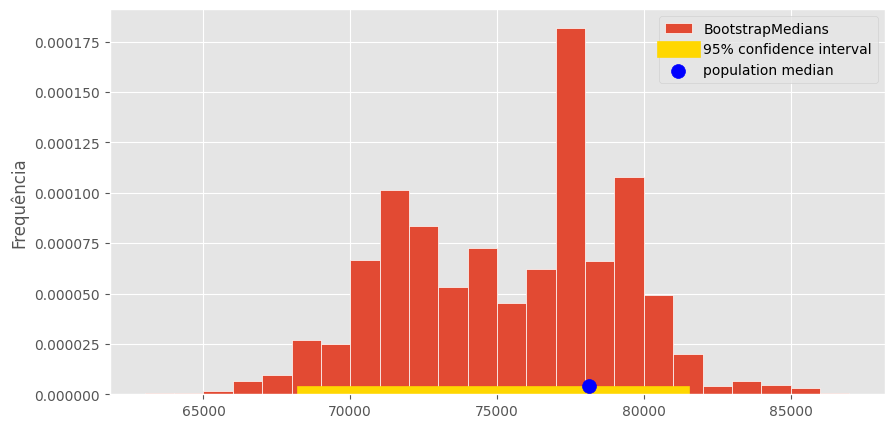

In [6]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='gold', linewidth=12, label='95% confidence interval');
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median').set_zorder(3)
plt.legend()
plt.ylabel("Frequência");

### Intervalos de confiança são estimativas _intervalares_ para um parâmetro

Aprendemos na aula passada que, com base nos intervalos de confiança (IC), ao invés de simplesmente afirmar

> "podemos dizer que a mediana populacional é _próxima_ da mediana amostral, \\$76,237",

nós podemos afirmar

> "podemos dizer, _com 95% de confiança_, que mediana populacional está entre \\$68,469 e \\$81,253.50".

**Na aula de hoje, vamos responder as seguintes perguntas**: "Mas afinal, o que 95% de confiança significa?" "Sobre o quê estamos confiantes?" "Esse tipo de técnica sempre funciona?"

### Interpretando intervalos de confiança

- Criamos um IC que contém 95% das medianas das nossas amostras bootstrap.
- Esperamos que a mediana populacional também esteja contida nesse IC.
- Porém, o quão seguros estamos desse fato? **Dizemos que "podemos afirmar isso com 95% de confiança", mas o que isso significa?**

### Capturando o verdadeiro valor do parâmetro

- Considere o seguinte passo-a-passo:
    1. Coletar uma **amostra nova** da população.
    1. Bootstrap: reamostrar dessa amostra várias vezes, calculando a estatística de interesse (por exemplo a mediana) em cada amostra.
    1. Construir um IC95%.

- Um nível de 95% de confiança então significa que, **em aproximadamente 95% das vezes em que realizamos esse processo, o intervalo criado conterá o verdadeiro valor do parâmetro**.
    - Em outras palavras: se pudéssemos repetir nosso experimento aleatório um número muito grande de vezes, 95% dos intervalos de confiança vão conter o verdadeiro valor do parâmetro.

- Dessa forma, a confiança reside no **processo** que gera o intervalo!

### Intervalos de confiança são como um jogo de argolas!

O ([GIF abaixo](https://twitter.com/EpiEllie/status/1160395672706789376)) contém uma explicação intuitiva dos intervalos de confiança.

In [7]:
Video('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/16-Confianca/data/ci-ring-toss.mp4', width=500)

In [8]:
show_confidence_interval_slides()

### Múltiplos intervalos de confiança

- Repetimos o passo-a-passo descrito acima $M = 200$ vezes, obtendo $M = 200$ ICs diferentes.
    - Fizemos isso de antemão (demorou um bom tempo) e salvamos os resultados em um arquivo.
- Os ICs obtidos estão contidos no array `many_cis` abaixo.

In [9]:
! wget https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/16-Confianca/data/many_cis.npy

--2025-03-18 10:48:34--  https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/16-Confianca/data/many_cis.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3328 (3.2K) [application/octet-stream]
Saving to: ‘many_cis.npy’

many_cis.npy        100%[===================>]   3.25K  --.-KB/s    in 0s      

2025-03-18 10:48:34 (10.2 MB/s) - ‘many_cis.npy’ saved [3328/3328]



In [10]:
many_cis = np.load('many_cis.npy')
many_cis

array([[72881.5 , 85383.32],
       [66727.19, 81871.47],
       [65449.32, 82001.4 ],
       ...,
       [64915.5 , 81814.85],
       [66702.5 , 79711.  ],
       [67996.76, 82105.84]])

Na visualização abaixo:
- A <span style="color:blue">linha azul</span> representa o parâmetro populacional. **Lembre que o parâmetro não é aleatório.**
- Cada <span style="color:gold">linha dourada</span> representa um IC diferente, obtido utilizado o passo-a-passo descrito anteriormente.
- Note que a _maioria_ dos ICs contém o parâmetro verdadeiro, mas _não todos_!

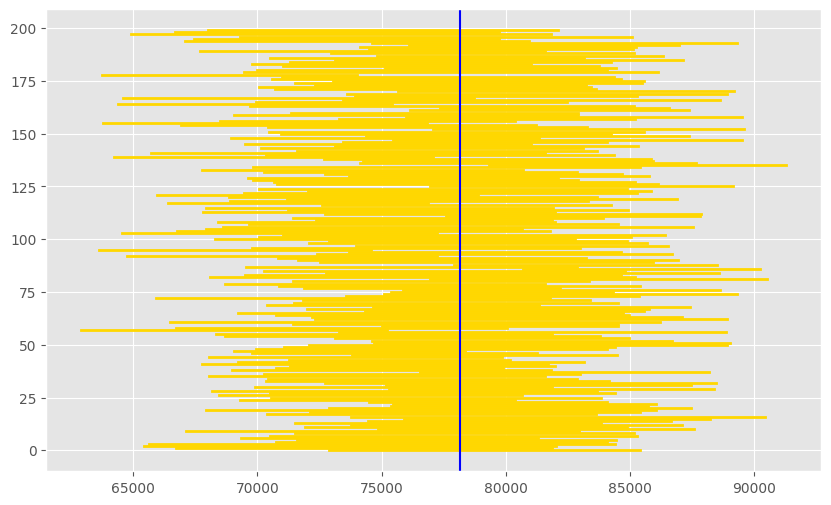

In [11]:
plt.figure(figsize=(10, 6))
for i, ci in enumerate(many_cis):
    plt.plot([ci[0], ci[1]], [i, i], color='gold', linewidth=2)
plt.axvline(x=population_median, color='blue');

### Quais ICs não contém o parâmetro populacional?

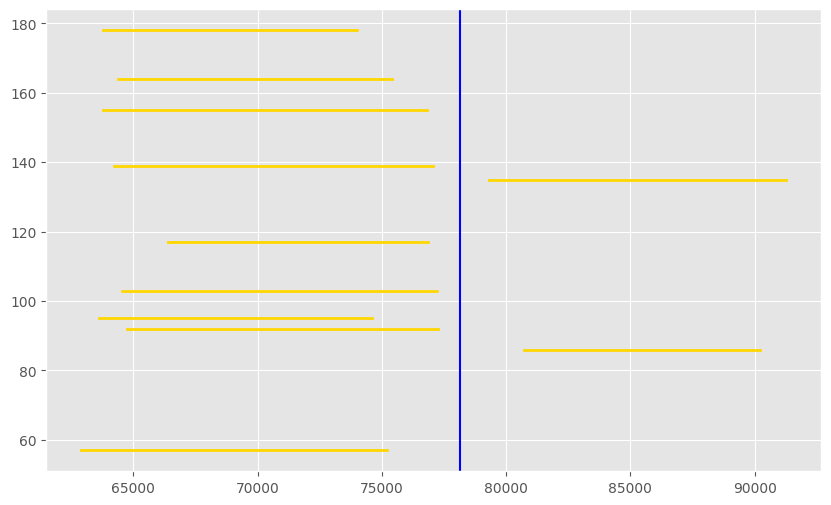

In [12]:
plt.figure(figsize=(10, 6))
count_outside = 0
for i, ci in enumerate(many_cis):
    if ci[0] > population_median or ci[1] < population_median:
        plt.plot([ci[0], ci[1]], [i, i], color='gold', linewidth=2)
        count_outside = count_outside + 1
plt.axvline(x=population_median, color='blue');

In [13]:
count_outside

11

- 11 dos nossos $M = 200$ ICs não contém o verdadeiro valor do parâmetro.
- Por outro lado, isso significa que 189/200, ou 94.5% dos ICs, contém sim o parâmetro populacional!
    - Não coincidentemente, 94.5% é bem próximo de 95%!

- Na prática, como coletamos apenas **uma única amostra**, teremos apenas **um único IC correspondente**, e não saberemos com certeza se esse IC contém ou não o verdadeiro valor do parâmetro.
    - Se em um certo sentido nossa amostra não for "boa", isto é, com uma distribuição que seja próxima da distribuição populacional, então nossa inferência será prejudicada.

### Escolhendo o nível de confiança

- Quando coletamos uma amostra "ruim" (isto é, que não tenha uma distribuição próxima da populacional), ao construírmos nosso IC é bem provável que esse IC não contenha o verdadeiro valor do parâmetro.
    - Podemos tentar remediar essa situação escolhendo um nível de confiança mais apropriado, mas note que existe um _tradeoff_ associado à isso! 

- Se, por exemplo, escolhermos um nível de confiança igual a 99%: 
    - aproxidamente apenas 1% das vezes nosso IC não conterá o verdadeiro valor do parâmetro (o que é ótimo!). Porém, ...
    - nossos ICs serão muito largos, e logo não muito úteis na prática.

- Se por outro lado escolhermos um nível de confiança igual a 80%: 
    - muitas das vezes (~20%) o IC não conterá o verdadeiro valor do parâmetro (o que não é tão bom assim). Porém, ...
    - nossos ICs nesse caso serão bem mais curtos, e logo mais precisos.

- O _tradeoff_ principal nesse contexto é então entre **confiança e precisão**.
    - Quanto **mais confiante** eu estou de que uma afirmativa é verdadeira, **menos preciso** essa afirmativa será, e vice-versa.
    - Por exemplo, se eu afirmo que hoje vai começar a chover _exatamente_ às 13:14 (uma afirmativa bem precisa), em geral eu quase sempre estarei errado sobre isso (e, logo, pouco confiante).
    - Por outro lado, se eu afirmo que vai chover _algum dia_ desse ano (uma afirmativa muito precisa), em geral eu quase sempre estarei correto sobre isso (e, logo, muito confiante).   

- Para um dado nível de confiança fixo, como então podemos fazer com que nosso IC seja mais curto (i.e. mais preciso)?
    - Coletando uma amostra maior!
    - Veremos adiante mais detalhes sobre a relação entre o tamanho amostral, o nível de confiança e a largura do IC. 

### Como _não_ interpretar intervalos de confiança

Fato: intervalos de confiança podem ser complicados de interpretar corretamente.

In [14]:
# Our interval:
print('Nosso IC95% é dado por:')
[left, right]

Nosso IC95% é dado por:


[68469.0, 81253.5]

**O intervalo acima contém 95% de todos os salários da população? Não!** ❌

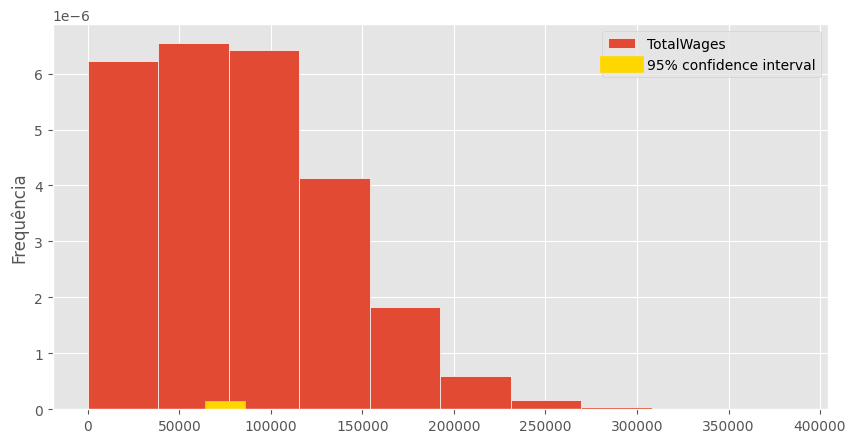

In [15]:
population.plot(kind='hist', y='TotalWages', density=True, ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='gold', linewidth=12, label='95% confidence interval');
plt.legend()
plt.ylabel("Frequência");

Por outro lado, o IC95% _contém sim_ 95% de todos os salários medianos obtidos pelo bootstrap.

> Em outras palavras, o IC95% contém 95% de todos os valores da _distribuição bootstrap_ (mas não da população).

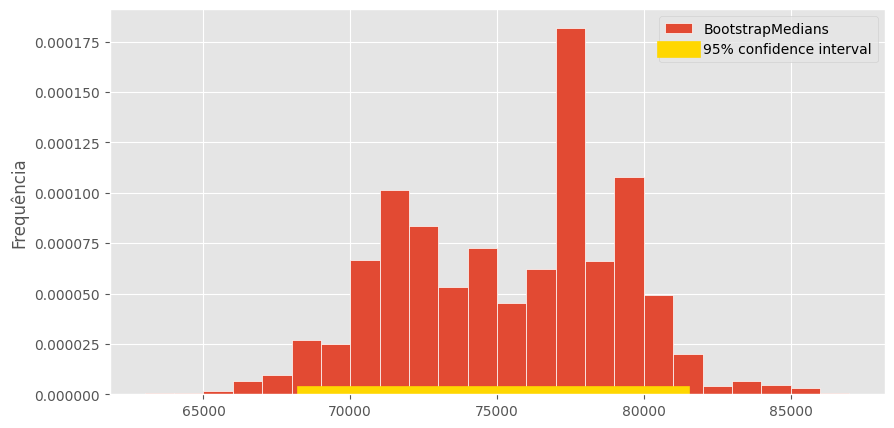

In [16]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='gold', linewidth=12, label='95% confidence interval');
plt.legend()
plt.ylabel("Frequência");

In [17]:
# Our interval:
print('Nosso IC95%:')
[left, right]

Nosso IC95%:


[68469.0, 81253.5]

**Então com 95% de probabilidade esse intervalo contém o parâmetro populacional? Também não!** ❌

E porque não?
- O parâmetro populacional é fixo, i.e. **não-aleatório**(embora desconhecido).
    - O intervalo obtido também é não-aleatório (embora o processo que o produza seja).
    - Para um dado intervalo, ou o parâmetro populacional está no intervalo ou não está. Logo, também não há aleatoriedade quanto a esse ponto.
- Lembre que o nível de confiança (nesse caso 95%) está relacionado ao quão preciso estamos sendo ao construirmos o intervalo.
    - Dessa forma, todo o processo de criar o IC (amostragem, bootstrapping e finalmente produzir o intervalo) produz um IC que contém o verdadeiro valor do parâmetro em aproximadamente 95% dos casos.

## "Armadilhas" do bootstrap

### Regras de bolso

- Bootstrap é uma técnica bem poderosa! Nós apenas precisamos coletar uma única amostra para obter uma distribuição aproximada para a mediana amostral.

- Porém, essa técnica tem suas limitações:
    - O bootstrap não é muito bom para estatísticas mais "sensíveis" a valores extremos (como por exemplo o máximo, ou o mínimo).
         - Essa técnica funciona melhor para estatísticas que são mais "robustas" (a _outliers_).
    - O boostrap fornece bons resultados apenas se a amostra é "suficientemente próxima" da população.
        - Se nossa amostra original **não for representativa da população**, as amostras bootstrap também não serão representativas da população.

### Exemplo: Estimando o máximo de uma quantidade populacional

- Suponha que, ao invés da mediana, estejamos agora interessados no _máximo_ dos salários de todos os funcionários públicos da cidade de San Diego (nossa população).
- Nossa amostra coletada continua a mesma que tínhamos anteriormente, `my_sample`.
- Nossa estimativa será igual ao máximo dos salários amostrais (i.e. o maior salário contido na amostra). Esse máximo é uma estatística.

- Para obter uma distribuição empírica do máximo, fazemos então o seguinte bootstrap:

In [18]:
n_resamples = 5000
boot_maxes = np.array([])

for i in range(n_resamples):
    resample = my_sample.sample(500, replace=True)
    boot_max = resample.get('TotalWages').max()
    boot_maxes = np.append(boot_maxes, boot_max)

In [19]:
boot_maxes

array([339416., 347755., 347755., ..., 257627., 339416., 339416.])

### Visualizando os resultados

Como aqui temos acesso à população, podemos encontrar o máximo populacional direto (sem bootstrap), apenas para comparação.

In [20]:
population_max = population.get('TotalWages').max()
population_max

384909

Então, será que o máximo populacional se encontra na parte com "mais massa" da distribuição bootstrap?

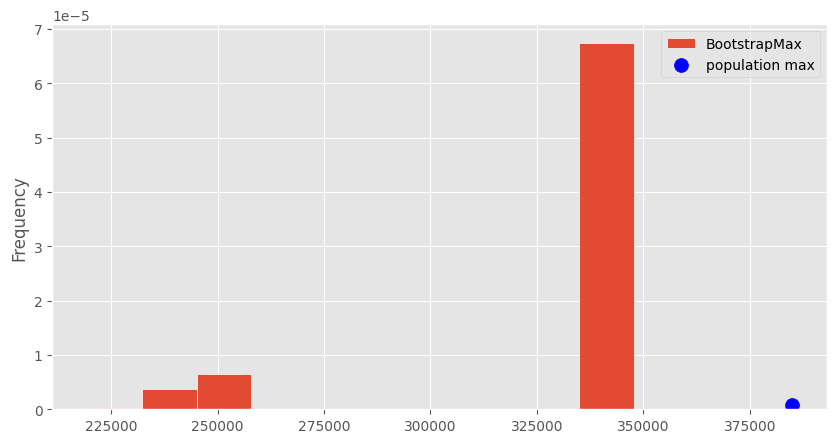

In [21]:
bpd.DataFrame().assign(BootstrapMax=boot_maxes).plot(kind='hist', 
                                                     density=True, 
                                                     bins=10,
                                                     ec='w',
                                                     figsize=(10, 5))
plt.scatter(population_max, 0.0000008, color='blue', s=100, label='population max')
plt.legend();

Na verdade não! A distribuição bootstrap (e os ICs que podemos construir através dela) não captura muito bem o máximo populacional, representado no histograma acima pelo <span style="color:blue"><b>ponto azul</b></span> igual a \$384,909.

> E porque não?! 🤔

In [22]:
my_sample.get('TotalWages').max()

347755

- O maior valor na nossa amostra original é de \\$347,755. Logo, o maior valor na nossa amostra bootstrap será no máximo igual a \\$347,755.

- Em geral, o bootstrap funciona melhor para medidas de tendência central ou dispersão (como a média, mediana, desvio padrão, etc.) do que para medidas que são mais sensíveis a outliers, como os extremos (máximo e mínimo).

## Medidas de tendência central e dispersão

### Reflexões e questionamentos

- Se soubermos a média e o desvio padrão de uma distribuição (mas nada mais que isso), o que podemos dizer sobre a forma dessa distribuição?

- O que é a distribuição Normal, e qual a relação dessa distribuição com algumas das outras distribuições que já vimos até agora?

- Vamos tentar responder essas perguntas ao longo dessa e das próximas aulas.

- Começaremos com algumas maneiras de medirmos a tendência central e dispersão de uma distribuição.

### Tendência central

- Uma medida de **tendência central** descreve _onde_ (ou seja, ao redor de qual valor) uma distribuição está centralizada.
    - A tendência central de uma distribuição é algumas vezes também denominada de _parâmetro de locação_ dessa distribuição.
    - A intuição por trás dessa nomenclatura vem do fato de que as distribuições em geral têm padrões de variabilidade _em torno_ das medidas de tendência central, o que é equivalente a dizer que uma distribuição está _localizada_ em torno do seu centro.

- Até agora, já vimos duas medidas de tendência central: a **média** e a **mediana**.

### Teste rápido ✅

Considere os seguintes histogramas, correspondentes a duas distribuições diferentes:

<center>
    <table><tr>
        <td> <center><img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/16-Confianca/data/hist.jpg" width=70%></center>  </td>
        <td> <center><img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/16-Confianca/data/hist2.jpg" width=70%></center> </td>
    </tr></table>
</center>

As médias dessas distribuições são iguais ou diferentes? E suas medianas?

- A. Ambas são iguais.
- B. As médias são diferentes, mas as medianas são iguais.
- C. As médias são iguais, mas as medianas são diferentes.
- D. Ambas são diferentes.

### Exemplo: Atrasos de vôos ✈️

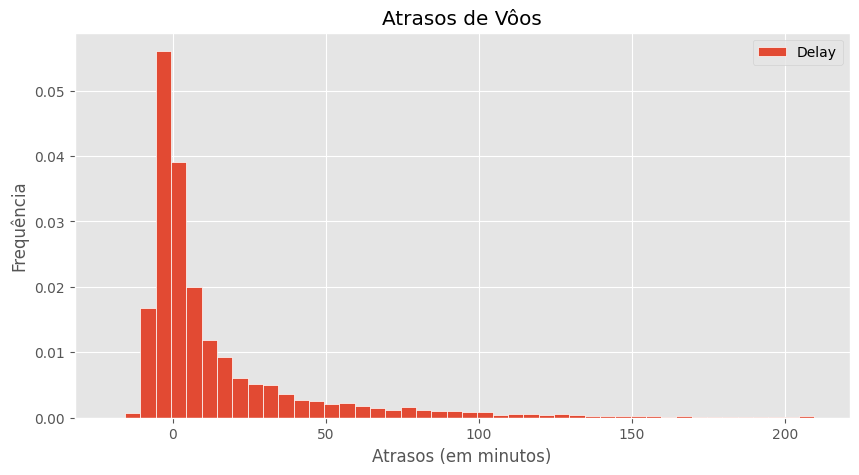

In [23]:
delays = bpd.read_csv('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/16-Confianca/data/united_summer2015.csv')
delays.plot(kind='hist', y='Delay', bins=np.arange(-20.5, 210, 5), density=True, ec='w', figsize=(10, 5))
plt.title('Atrasos de Vôos')
plt.xlabel('Atrasos (em minutos)')
plt.ylabel("Frequência");

**Pergunta**: Qual é maior nesta distribuição – a média ou a mediana?

In [24]:
delays.get('Delay').mean()

16.658155515370705

In [25]:
delays.get('Delay').median()

2.0

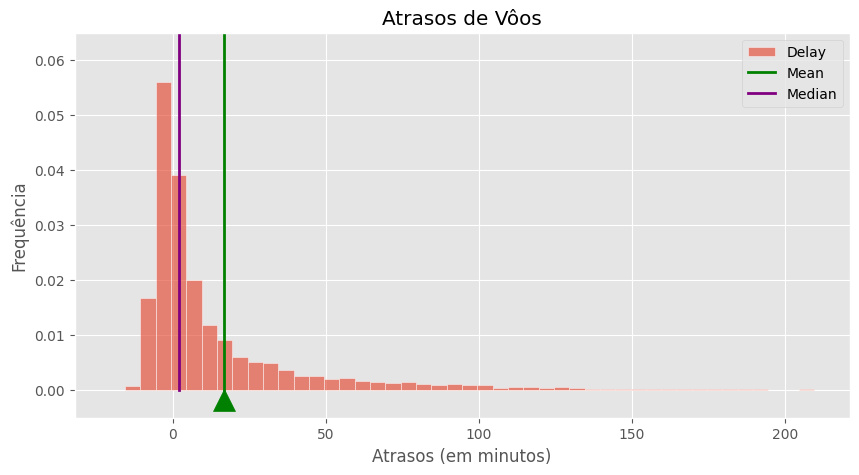

In [26]:
delays.plot(kind='hist', y='Delay', bins=np.arange(-20.5, 210, 5), density=True, ec='w', alpha=0.65, figsize=(10, 5))
plt.plot([delays.get('Delay').mean(), delays.get('Delay').mean()], [0, 1], color='green', label='Mean', linewidth=2)
plt.scatter([delays.get('Delay').mean()], [-0.0017], color='green', marker='^', s=250)
plt.plot([delays.get('Delay').median(), delays.get('Delay').median()], [0, 1], color='purple', label='Median', linewidth=2)
plt.title('Atrasos de Vôos')
plt.xlabel('Atrasos (em minutos)')
plt.ylim(-0.005, 0.065)
plt.legend()
plt.ylabel("Frequência");

## Média

- **Definição**: Soma de todos os elementos da amostra, divido pelo tamanho amostral $n$.
    - É comum denotarmos a média _populacional_ por $\mu$ e a média _amostral_ por $\bar{X}$.
    - Denotando nosso conjunto de observações por $\mathbf{X} := (X_1, \ldots, X_n)$, definimos então $\bar{X} := \sum^n_{i=1} X_i$.  

- Visualmente, a média amostral pode ser pensada como o "ponto de equilíbrio" do histograma acima.
    - A soma das diferenças entre cada ponto e a média é sempre igual a 0.
    - Uma analogia é pensar na média amostral como o ponto de apoio de uma gangorra.

## Mediana

- **Definição**: Ponto que divide a amostra ao meio.
    - Metade da área do histograma está à direita da mediana, e a outra metade à esquerda.
    - Usualmente denotamos a mediana populacional por $m(\mathbf{X})$, e a mediana amostral por $\hat{m}(\mathbf{X})$.

- A mediana é o percentil 50 de uma distribuição de probabilidades.

- Se uma distribuição é **simétrica** em torno de um valor, então esse valor coincide com ambas média e mediana.

- Se uma distribuição é **assimétrica** (_à direita_ ou _à esquerda_), então a média será diferente da mediana (respectivamente, à direita ou à esquerda, de acordo com a direção da assimetria).

- **Propriedade importante**: A mediana é mais **robusta** (menos **sensível**) a **_outliers_/valores extremos**.

## Desvio Padrão

### Como caracterizar a "largura" de uma distribuição? 

- Uma ideia natural seria tomarmos o maior valor e subtrair pelo menor valor encontrado na distribuição.
    - Essa medida é conhecida como a **amplitude** (_range_, em inglês) da distribuição.
    - Apesar de intuitiva, a amplitude não nos diz muito sobre a _forma_ da distribuição.
        - Além disso, a amplitude (populacional) de muitas distribuições que utilizaremos na prática é infinita, ou não é bem definida (por exemplo se nossa variável aleatória toma valores no conjunto dos números reais).

- Uma outra possibilidade seria utilizarmos o _desvio padrão_ da distribuição.
    - O desvio padrão é uma medida do quanto, _em média_, as observações _estão distantes da média_.

### Desvios em torno da média

- Para medir o quão distante cada observação está da média, simplesmente tomamos a diferença entre aquela observação e a média.
    -   Essa quantidade é conhecida como _desvio em torno da média_.
    -   Formalmente, se $X_i$ é a $i$-ésima observação da nossa amostra $\mathbf{X}$, definimos o _desvio de $X_i$ em torno da média amostral $\bar{X}$_ por $X_i - \bar{X}$, para $i = 1, \ldots, n$.

Considere então o seguinte exemplo:

In [27]:
data = np.array([2, 3, 3, 9])
np.mean(data)

4.25

In [28]:
deviations = data - np.mean(data)
deviations

array([-2.25, -1.25, -1.25,  4.75])

Cada entrada em `deviations` mede o desvio do elemento correspondente em `data` em torno da média (4.25).

E qual é o desvio médio, nesse caso?

In [29]:
np.mean(deviations)

0.0

- **Fato**: a média dos desvios em torno da média é _sempre igual a 0_, independente da distribuição ser amostral ou populacional.
    - Uma consequência disso é que o desvio médio em torno da média acaba não sendo então uma medida útil da dispersão de uma distribuição.

### Desvios em torno da média, **ao quadrado**

Vamos agora tomar o quadrado dos desvios em torno da média:

In [30]:
# Square all the deviations:
deviations ** 2

array([ 5.06,  1.56,  1.56, 22.56])

e então tomar a média dos desvios ao quadrado:

In [31]:
variance = np.mean(deviations ** 2)
variance

7.6875

A quantidade calculada acima, isto é, a _média dos desvios quadrados em torno da média_, é conhecido como **variância**.

### Raiz quadrada da soma dos quadrados?

- Apesar da variância ser uma medida muito útil de dispersão, em geral ela possui um problema de interpretação: a _unidade_ na qual a variância é expressa não é igual à de cada $X_i$, mas sim de $X_i^2$!   
- Por exemplo, se nossos dados estão em $\text{USD}$ ou $\text{BRL}$ (dólares ou reais), a variância estará expressa em $\text{USD}^2$ ou $\text{BRL}^2$.
- Para contornar esse problema de interpretabilidade, tomamos então a _raiz quadrada_ da variância, e o resultado é conhecido como **desvio padrão**.

In [32]:
# Standard deviation (SD) is the square root of the variance.
sd = variance ** 0.5
sd

2.7726341266023544

### Desvio padrão

- **Definição**: Raiz da média dos desvios (em torno da média) ao quadrado.
    - Usualmente denotamos a variância populacional por $\sigma^2$, o desvio padrão (DP) populacional por $\sigma$, e os análogos amostrais por $S$ e $S^2$, respectivamente.

Formalmente,

$$\begin{align*}
    S^2 &:= \frac{\sum^n_{i=1} (X_i - \bar{X})^2}{n}, & S &= \sqrt{S^2} = \sqrt{\frac{\sum^n_{i=1} (X_i - \bar{X})^2}{n}}.
\end{align*}$$

- O DP (que também é representado pela sigla em inglês, SD, de _standard deviation_) mede o _quão distantes_ os valores em uma distribuição estão de sua média.
    - Equivalentemente, o DP mede o quão _dispersos_ são os valores de uma distribuição (em torno de sua média).  
    - Dessa forma, quanto maior o DP, mais dispersos serão os dados.

- Lembre que, crucialmente, o desvio padrão é expresso nas mesmas unidades de $\mathbf{X}$.

- A biblioteca `numpy` tem uma função, `np.std`, que calcula o desvio padrão de um conjunto de dados.

In [33]:
# Note that this evaluates to the same number we found on the previous cell.
np.std(data)

2.7726341266023544

### E como podemos utilizar o desvio padrão na prática?

Na prática, a grande maioria dos valores de uma distribuição estão "a alguns DPs da média", isto é, no intervalo $\bar{X} \pm k \cdot \sigma$, onde $k \in \mathbb{N}$.

Vamos agora formalizar um pouco essa intuição.

### Desigualdade de Chebyshev

**Fato**: Para **"qualquer"** distribuição de probabilidade, a probabilidade dos valores estarem entre "média ± $k$ DPs" (ou a $k$ DPs da média) é sempre maior ou igual a

$$1 - \frac{1}{k^2}
$$

Esse fato decorre da **Desigualdade de Chebyshev**, uma ferramenta bem importante no estudo de Probabilidade.

A tabela a seguir contém as probabilidades correspondentes para alguns valores de $k$:

| $k$ | Intervalo | Probabilidade |
| ----- | ----- | ----- |
|$k = 1$| $\bar{X} \pm 1 \cdot \sigma$| $\geq 1 - \frac{1}{1} =  0%$|
|$k = 2$| $\bar{X} \pm 2 \cdot \sigma$| $\geq 1 - \frac{1}{4} = 75%$|
|$k = 3$| $\bar{X} \pm 3 \cdot \sigma$| $\geq 1 - \frac{1}{9} \simeq 88.88%$|
|$k = 4$| $\bar{X} \pm 4 \cdot \sigma$| $\geq 1 - \frac{1}{16} = 93.75%$|
|$k = 5$| $\bar{X} \pm 5 \cdot \sigma$| $\geq 1 - \frac{1}{25} = 96%$|

### Atrasos de vôos (mais uma vez)

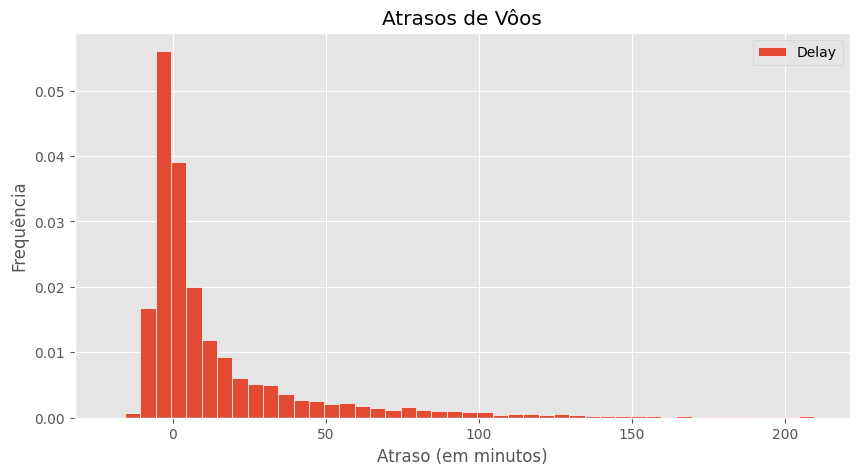

In [34]:
delays.plot(kind='hist', y='Delay', bins=np.arange(-20.5, 210, 5), density=True, ec='w', figsize=(10, 5), title='Atrasos de Vôos')
plt.xlabel('Atraso (em minutos)')
plt.ylabel("Frequência");

In [35]:
delay_mean = delays.get('Delay').mean()
delay_mean

16.658155515370705

In [36]:
delay_std = np.std(delays.get('Delay')) # There is no .std() method in babypandas!
delay_std

39.480199851609314

### Média e desvio padrão

A Desigualdade de Chebyshev nos diz que

- **Pelo menos** 75% dos atrasos de vôos estão no seguinte intervalo:

In [37]:
delay_mean - 2 * delay_std, delay_mean + 2 * delay_std

(-62.30224418784792, 95.61855521858934)

- **Pelo menos** 88.88% dos atrasos estão no seguinte intervalo:

In [38]:
delay_mean - 3 * delay_std, delay_mean + 3 * delay_std

(-101.78244403945723, 135.09875507019865)

Vamos visualizar esses intervalos:

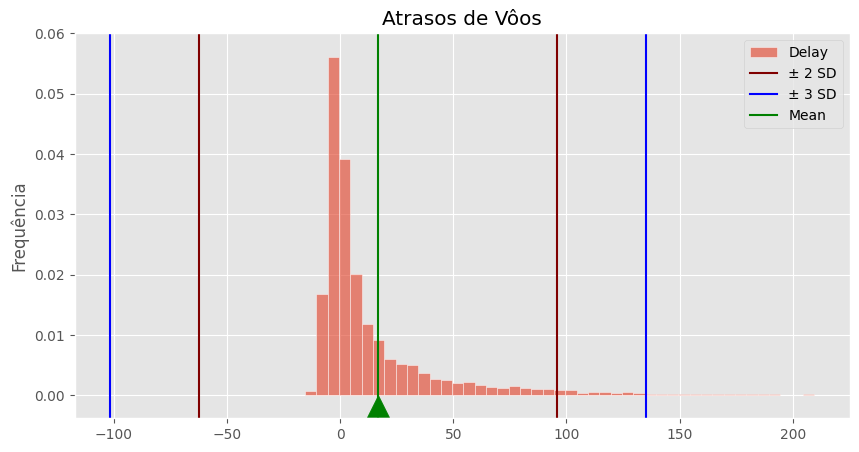

In [39]:
delays.plot(kind='hist', y='Delay', bins=np.arange(-20.5, 210, 5), density=True, alpha=0.65, ec='w', figsize=(10, 5), title='Atrasos de Vôos')
plt.axvline(delay_mean - 2 * delay_std, color='maroon', label='± 2 SD')
plt.axvline(delay_mean + 2 * delay_std, color='maroon')

plt.axvline(delay_mean + 3 * delay_std, color='blue',  label='± 3 SD')
plt.axvline(delay_mean - 3 * delay_std, color='blue')

plt.axvline(delay_mean, color='green', label='Mean')
plt.scatter([delay_mean], [-0.0017], color='green', marker='^', s=250)
plt.ylim(-0.0038, 0.06)
plt.legend()
plt.ylabel("Frequência");

### A Desigualdade de Chebyshev nos fornece apenas _limites inferiores_!

Lembre que a Desigualdade de Chebyshev nos diz que, **pelo menos** $1 - \frac{1}{k^2}$ dos valores de uma distribuição estão a até $k$ DPs da média.

No caso dos atrasos de vôos, a Desigualdade de Chebyshev nos diz então que **pelo menos** 75% dos atrasos estão dentro do seguinte intervalo:

In [40]:
delay_mean - 2 * delay_std, delay_mean + 2 * delay_std

(-62.30224418784792, 95.61855521858934)

Na verdade, porém, a proporção de atrasos de vôos contida nesse intervalo é muito maior:

In [41]:
within_2_sds = delays[(delays.get('Delay') >= delay_mean - 2 * delay_std) & 
                      (delays.get('Delay') <= delay_mean + 2 * delay_std)]

within_2_sds.shape[0] / delays.shape[0]

0.9560940325497288

Quando sabemos mais sobre o comportamento (ou a forma) de uma distribuição, podemos fazer afirmativas mais precisas que a Desigualdade de Chebyshev em termos da probabilidade dos valores que estão a $k$ DPs da média.

### Desafio

Considere que, para um certo conjunto de dados, a Desigualdade de Chebyshev nos permita dizer que pelo menos $\frac{8}{9}$ das observações estão contidas no intervalo entre $-20$ e $40$. Qual é o desvio padrão desse conjunto de dados?


<details><summary>✅ Clique aqui para ver a resposta <b>depois</b> de tentar por conta própria.</summary>

- A Desigualdade de Chebyshev nos diz que pelo menos $1 - \frac{1}{k^2}$ dos valores estão a $k$ desvios padrão da média.
- Encontramos primeiro o valor de $k$, resolvendo a equação $1 - \frac{1}{k^2} = \frac{8}{9}$, resultando em $k = 3$.
- Dessa forma, o valor de $-20$ está a $3$ DPs abaixo da média, e o valor de $40$ está a $3$ DPs acima da média.
- O ponto médio entre $-20$ e $40$ é igual a $10$, então a média é igual a $\bar{X} = 10$.
- Como $k = 3$ DPs estão entre $10$ and $40$ (ou entre $-20$ e $10$), então $1$ DP é igual a $\sigma = \frac{30}{3} = 10$.
</details>

## Resumo e próxima aula

### Resumo: Bootstrap e intervalos de confiança

- O boostrap nos fornece uma maneira de construir uma distribuição empírica de uma estatística com base em uma única amostra. Com a distribuição bootstrap, podemos criar intervalos de $\gamma\%$ de confiança tomando como limite inferior e superior percentis que contenham $\gamma\%$ da distribuição bootstrap.
- Um IC construído dessa maneira nos permite quantificar a incerteza sobre a nossa estimativa do parâmetro populacional.
    - Dessa forma, ao invés de reportar apenas uma estimativa pontual para o parâmetro de interesse, podemos reportar um conjunto de estimativas.
- **Intervalos de confiança precisam ser interpretados com cuidado.** A "confiança" reside no processo que gera os intervalos, e não em um IC em particular.
- O bootstrap funciona bem para estatísticas que não são tão sensíveis à pequenas variações na amostra (tais como a média e a mediana, mas não para máximos e mínimos).

### Resumo: Tendência central, dispersão e a Desigualdade de Chebyshev

- A média e a mediana são medidas de tendência central.
- A variância e o desvio padrão (DP) são medidas de dispersão.
    - O DP é igual a raiz quadrada da variância.
    - Em linhas gerais, o desvio padrão mede, em média, o quão distantes da média os valores de uma distribuição estão.
- A Desigualdade de Chebyshev diz que, em qualquer distribuição, a probabilidade dos valores que estão a $k$ DPs da média é pelo menos igual a $1 - \frac{1}{k^2}$.
    - Dependendo da distribuição, a verdadeira probabilidade dos valores que estão a $k$ DPs da média pode ser _maior_ que $1 - \frac{1}{k^2}$, mas nunca _menor_.

### Próxima aula

O que é a distribuição "Normal", e qual é a relação dessa distribuição com algumas das distribuições que já vimos até agora?